In [500]:
if (!require('devtools')) install.packages('devtools')
devtools::install_github('behavioral-ds/evently')

library(evently)
setup_ampl("/root/ampl")

library(repr)
library(dplyr)

set.seed(13)

Skipping install of 'evently' from a github remote, the SHA1 (9be4daa8) has not changed since last install.
  Use `force = TRUE` to force installation



## 1. Analiza zbioru i uzasadnienie, dlaczego nadaje się do modelowania procesem Hawkesa (2 pkt)


In [501]:
dataset <- read.csv("data.csv")

In [502]:
index <- read.csv("index.csv")

In [503]:
head(dataset, n=5)

,relative_time_second,number_of_followers
,<dbl>,<dbl>
1,0,33
2,84833,46828
3,84878,208
4,84883,37
5,84900,137


In [504]:
dataset[175:176,]

,relative_time_second,number_of_followers
,<dbl>,<dbl>
175,424201,148
176,0,40627


In [505]:
head(index, n=10)

,tweet_id,post_time_day,start_ind,end_ind
,<dbl>,<dbl>,<int>,<int>
1,1.224346e+17,0.9266435,1,175
2,1.224497e+17,0.9681597,176,369
3,1.224502e+17,0.9695602,370,703
4,1.224430e+17,0.9497338,704,827
5,1.224566e+17,0.9873727,828,941
6,1.223103e+17,0.5837269,942,1029
7,1.223634e+17,0.7300926,1030,2418
8,1.222954e+17,0.5425347,2419,2490
9,1.223526e+17,0.7002546,2491,2545


In [506]:
tail(index, n=5)

,tweet_id,post_time_day,start_ind,end_ind
,<dbl>,<dbl>,<int>,<int>
166072,1.250005e+17,8.007164,34784039,34784103
166073,1.250006e+17,8.007407,34784104,34784155
166074,1.259254e+17,10.559387,34784156,34784320
166075,1.255487e+17,9.519977,34784321,34784412
166076,1.254171e+17,9.156794,34784413,34784488


Zbiór danych pochodzi z http://snap.stanford.edu/seismic/ .

Zbiór danych składa się z dwóch plików - data.csv oraz index.csv.
Plik data.csv zawiera bezpośrednio dane o wpisach wchodzące w skład kaskady, natomiast plik index.csv zawiera podział na kaskady.
Przyjrzyjmy się pierwszej kaskadzie.
Pierwsza kaskada obejmuje wiersze od 1 do 175 w pliku data.csv. Pierwszy wiersz jest tweetem od którego wszystko się zaczęło, o czym świadczy 0 czas kolumny relative_time_second. Kolumna ta opisuje czas w sekundach, jaki upłynął od oryginalnego tweeta do jego retweeta.
Kolejne wiersze w ramach kaskady mają wzrastającą wartość tej kolumny.
Druga kolumna nazwana number_of_followers opisuje liczbę obserwujących użytkownika, który dokonał tweetu/retweetu. 

Zbiór ten nadaje się do modelowania procesem Hawkesa, gdyż zgodnie z opisem w jego źródle jest self-exciting i jest to bezpośrednio w nim widoczne. Dane składają się z tweeta i szeregu jego dalszych retweetów oraz są podzielone na kaskady.

## 2. Wybór odpowiedniego procesu Hawkesa/kernela do danych i dopasowanie parametrów dla dwóch kaskad (4 pkt)
## oraz
## 4. Przewidzenie końcowego rozmiaru kaskady (2 pkt)

### Przygotowanie kaskad

In [507]:
dataset = dataset %>% 
  rename(
    magnitude = number_of_followers,
    time = relative_time_second
    )

In [521]:
cascade_1 = dataset[176:369, ]
cascade_2 = dataset[34784156:34784320,]

cascades = list(cascade_1, cascade_2)

In [522]:
head(cascade_1, n=5)

,time,magnitude
,<dbl>,<dbl>
176,0,40627
177,40632,67
178,66629,434245
179,66662,395
180,66665,94


In [523]:
head(cascade_2, n=5)

,time,magnitude
,<dbl>,<dbl>
34784156,0,156
34784157,79632,293
34784158,79642,125
34784159,79662,67
34784160,79667,72


### Funkcja do trenowania

In [549]:
fit_model <- function(cascade, kernel_type, max_train_time_factor=0.4) {
  train_cascade = cascade[with(cascade, time <= max_train_time_factor * max(cascade$time)),]
  fitted_model <- fit_series(train_cascade, model_type = kernel_type, observation_time = max(train_cascade$time), cores = 2)
  
  branching_factor <- get_branching_factor(fitted_model)
  cat('Branching factor: ', branching_factor, '\n')
  cat('Rozmiar zbioru treningowego: ', nrow(train_cascade), '.\n')

  if (branching_factor < 1)
  {
    predicted = predict_final_popularity(fitted_model)
    real <- nrow(cascade)
      cat('Rozmiar kaskady: ', real, '. Predykowany rozmiar kaskady: ', predicted, '.\n')
      cat('Błąd względny wynosi: ', 100*abs(real-predicted)/real, '%\n')
  }
  else
  {
    cat('Nie można wypredykować rozmiaru kaskady, gdyż branching factor > 1.\n')
  }

  cat('Wytrenowany model: ')
  print(fitted_model)
  cat('\n')

  return(fitted_model)
}

## Kernel type EXP

In [550]:
fitted_model_EXP_1 <- fit_model(cascade_1, 'EXP', 0.15)
fitted_model_EXP_2 <- fit_model(cascade_2, 'EXP', 0.35)
fitted_model_EXP_1 <- fit_model(cascade_1, 'EXP', 0.4)
fitted_model_EXP_2 <- fit_model(cascade_2, 'EXP', 0.6)

Branching factor:  0.99999 
Rozmiar zbioru treningowego:  160 .
Rozmiar kaskady:  194 . Predykowany rozmiar kaskady:  101131.7 .
Błąd względny wynosi:  52029.72 %
Wytrenowany model: - Model: EXP 
- No. of cascades: 1 
- init_par:
  K 1.01e+00; theta 2.88e-01
- par:
  K 1.00e+00; theta 1.67e-03
- Neg Log Likelihood: 702.014 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 

Branching factor:  1 
Rozmiar zbioru treningowego:  125 .
Nie można wypredykować rozmiaru kaskady, gdyż branching factor > 1.
Wytrenowany model: - Model: EXP 
- No. of cascades: 1 
- init_par:
  K 9.44e+00; theta 1.90e+00
- par:
  K 1.00e+00; theta 1.30e-02
- Neg Log Likelihood: 660.417 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 

Branching factor:  0.999988 
Rozmiar zbioru treningowego:  165 .
Rozmiar kaskady:  194 . Predykowany rozmiar kaskady:  83497.37 .
Błąd względny wynosi:  42939.88 %
Wyt

Bazowa wersja Hawkesa z wykładniczą funkcja jądra sprawdziła się bardzo słabo dla przedstawionego problemu; branching factor osiąga bardzo wysokie wartości, a dla drugiej kaskady przy mniejszym rozmiarze zbioru treningowego przekroczył 1. Wysoki branching faktor spowodował, że dla drugiej kaskady predykowany rozmiar był gigantyczny co poskutkowało bardzo dużą wartością błędu względnego.

## Kernel type mEXP

In [551]:
fitted_model_EXP_1 <- fit_model(cascade_1, 'mEXP', 0.15)
fitted_model_EXP_2 <- fit_model(cascade_2, 'mEXP', 0.35)
fitted_model_EXP_1 <- fit_model(cascade_1, 'mEXP', 0.4)
fitted_model_EXP_2 <- fit_model(cascade_2, 'mEXP', 0.6)

Branching factor:  1.045074 
Rozmiar zbioru treningowego:  160 .
Nie można wypredykować rozmiaru kaskady, gdyż branching factor > 1.
Wytrenowany model: - Model: mEXP 
- No. of cascades: 1 
- init_par:
  K 9.82e+00; beta 3.48e-01; theta 7.79e-02
- par:
  K 8.23e-05; beta 1.02e+00; theta 1.45e-03
- Neg Log Likelihood: 626.993 
- lower_bound:
  K 1.00e-100; beta 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; beta 1.02e+00; theta 3.00e+02
- Convergence: 0 

Branching factor:  0.7298043 
Rozmiar zbioru treningowego:  125 .
Rozmiar kaskady:  165 . Predykowany rozmiar kaskady:  3200.796 .
Błąd względny wynosi:  1839.877 %
Wytrenowany model: - Model: mEXP 
- No. of cascades: 1 
- init_par:
  K 5.00e-01; beta 5.00e-01; theta 1.00e-05
- par:
  K 1.63e-01; beta 7.90e-01; theta 1.48e-04
- Neg Log Likelihood: 508.672 
- lower_bound:
  K 1.00e-100; beta 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; beta 1.02e+00; theta 3.00e+02
- Convergence: 0 

Branching factor:  0.9578035 
Rozm

Zastosowanie marked Hawkesa różni się znacząco w swoim działaniu od klasycznego Hawkesa - branching factor najczęściej osiąga niższe wartości, co skutkuje znacznie niższą wartością predykowanego rozmiaru kaskady, a w efekcie dla niniejszych danych - mniejszym błędem względnym. 

## 3. Porównanie dynamiki dwóch kaskad na podstawie parametrów procesu Hawkesa (2 pkt)

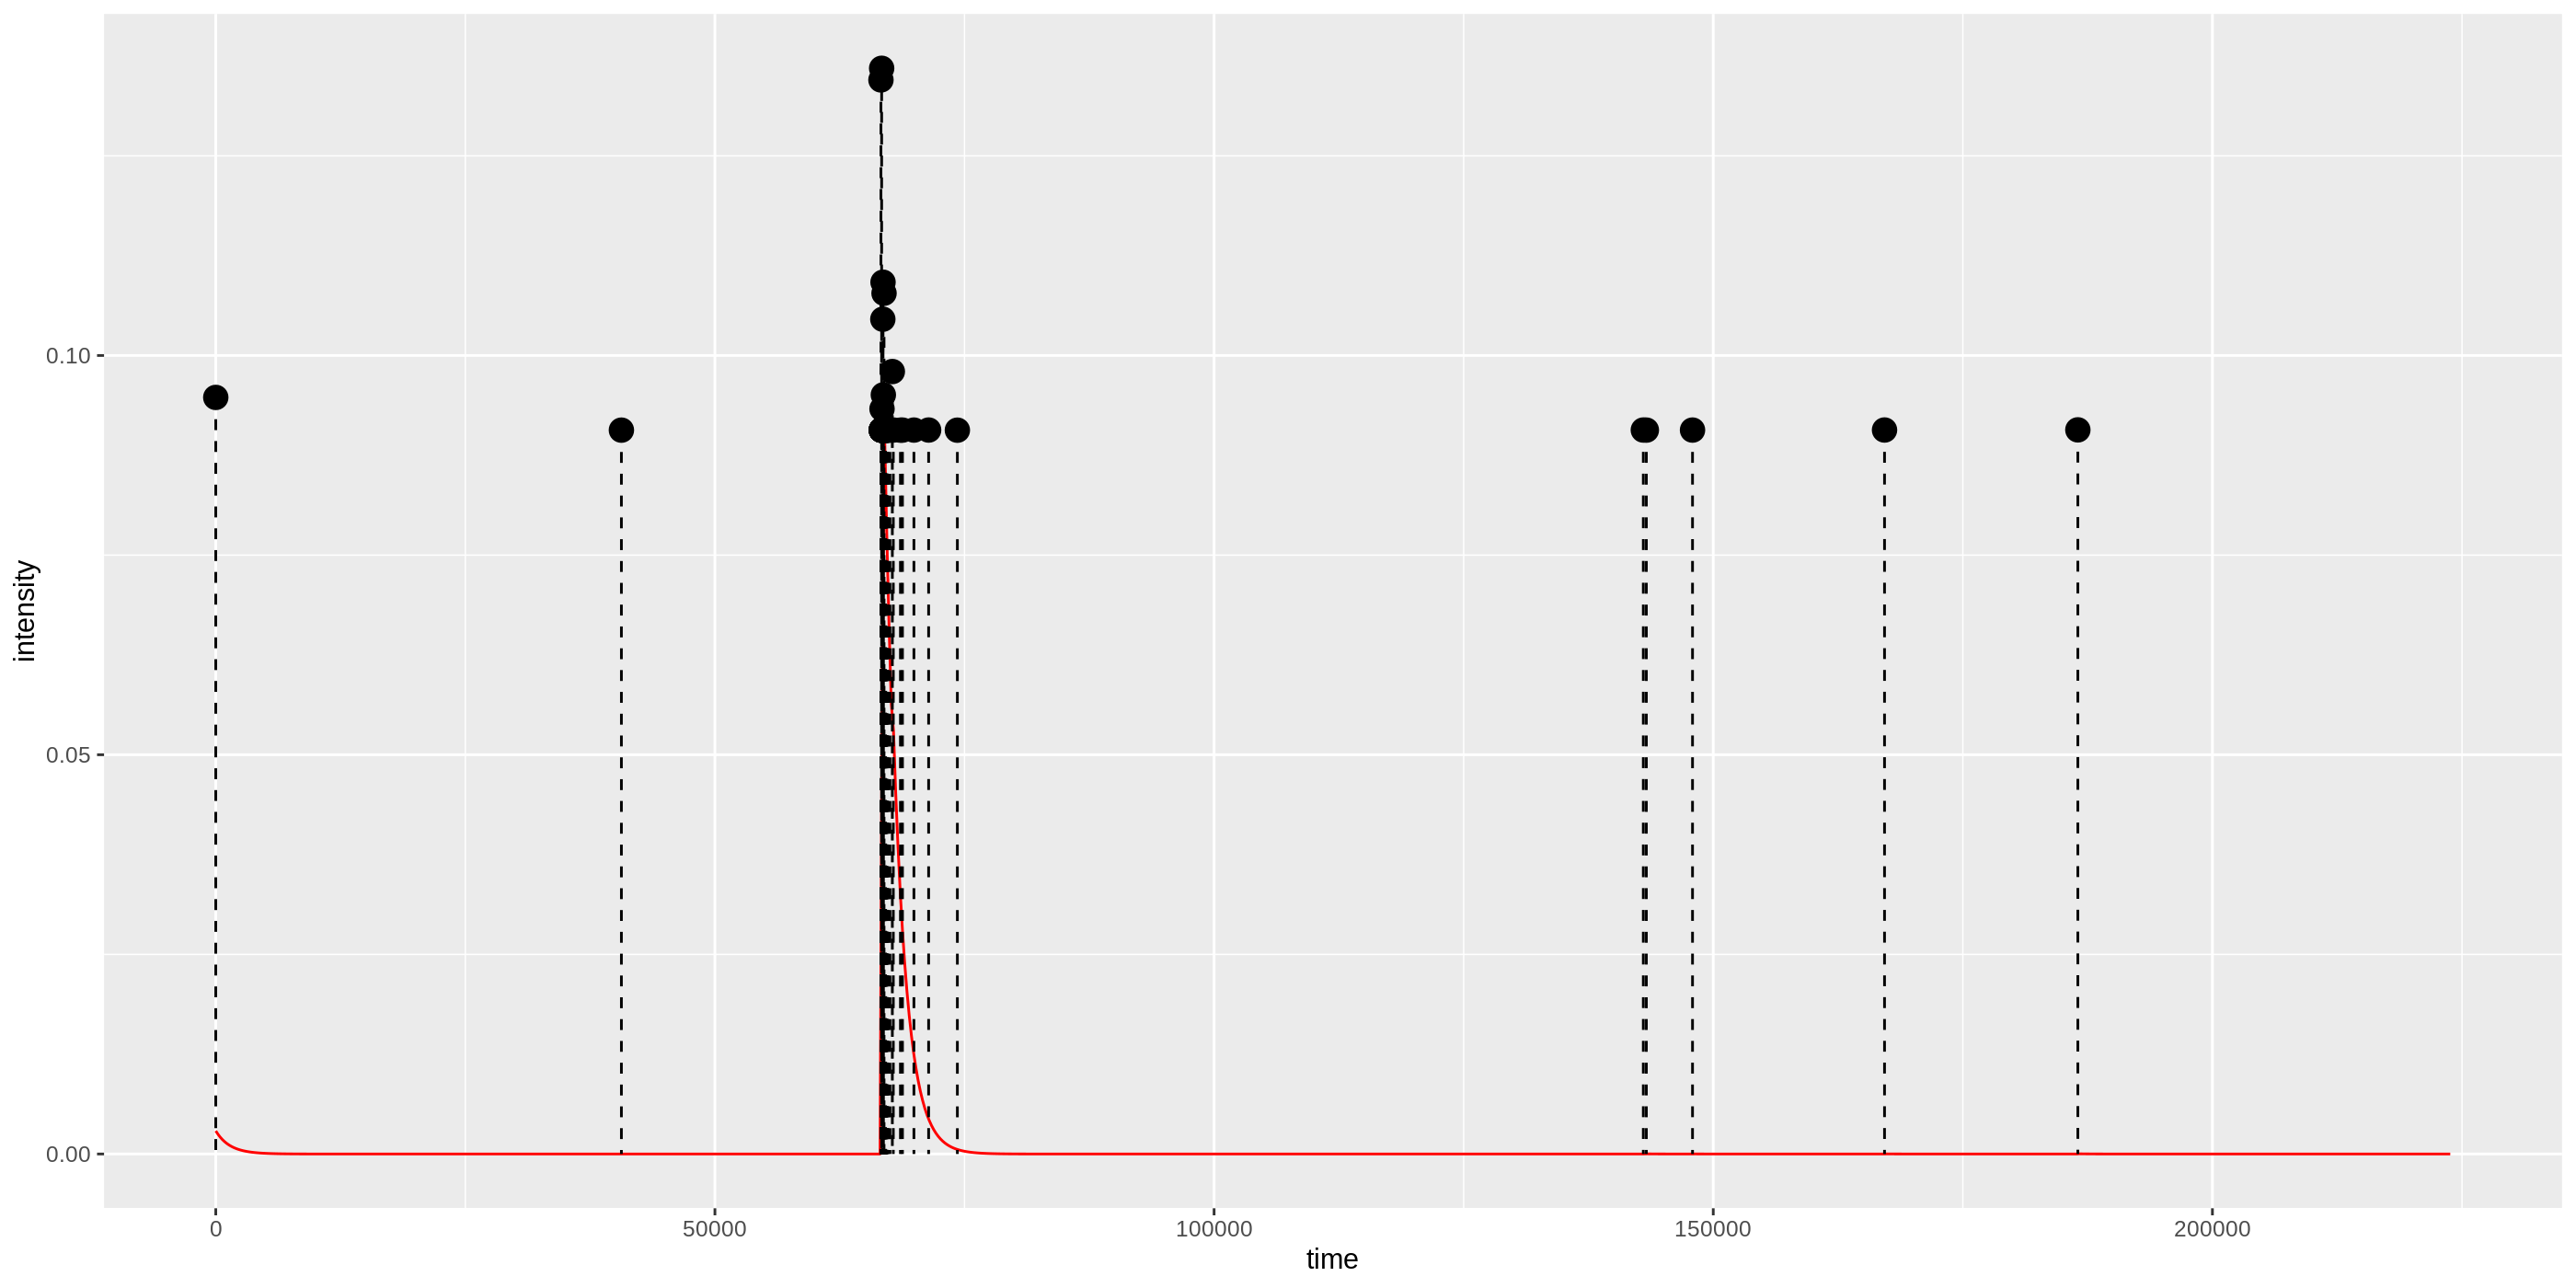

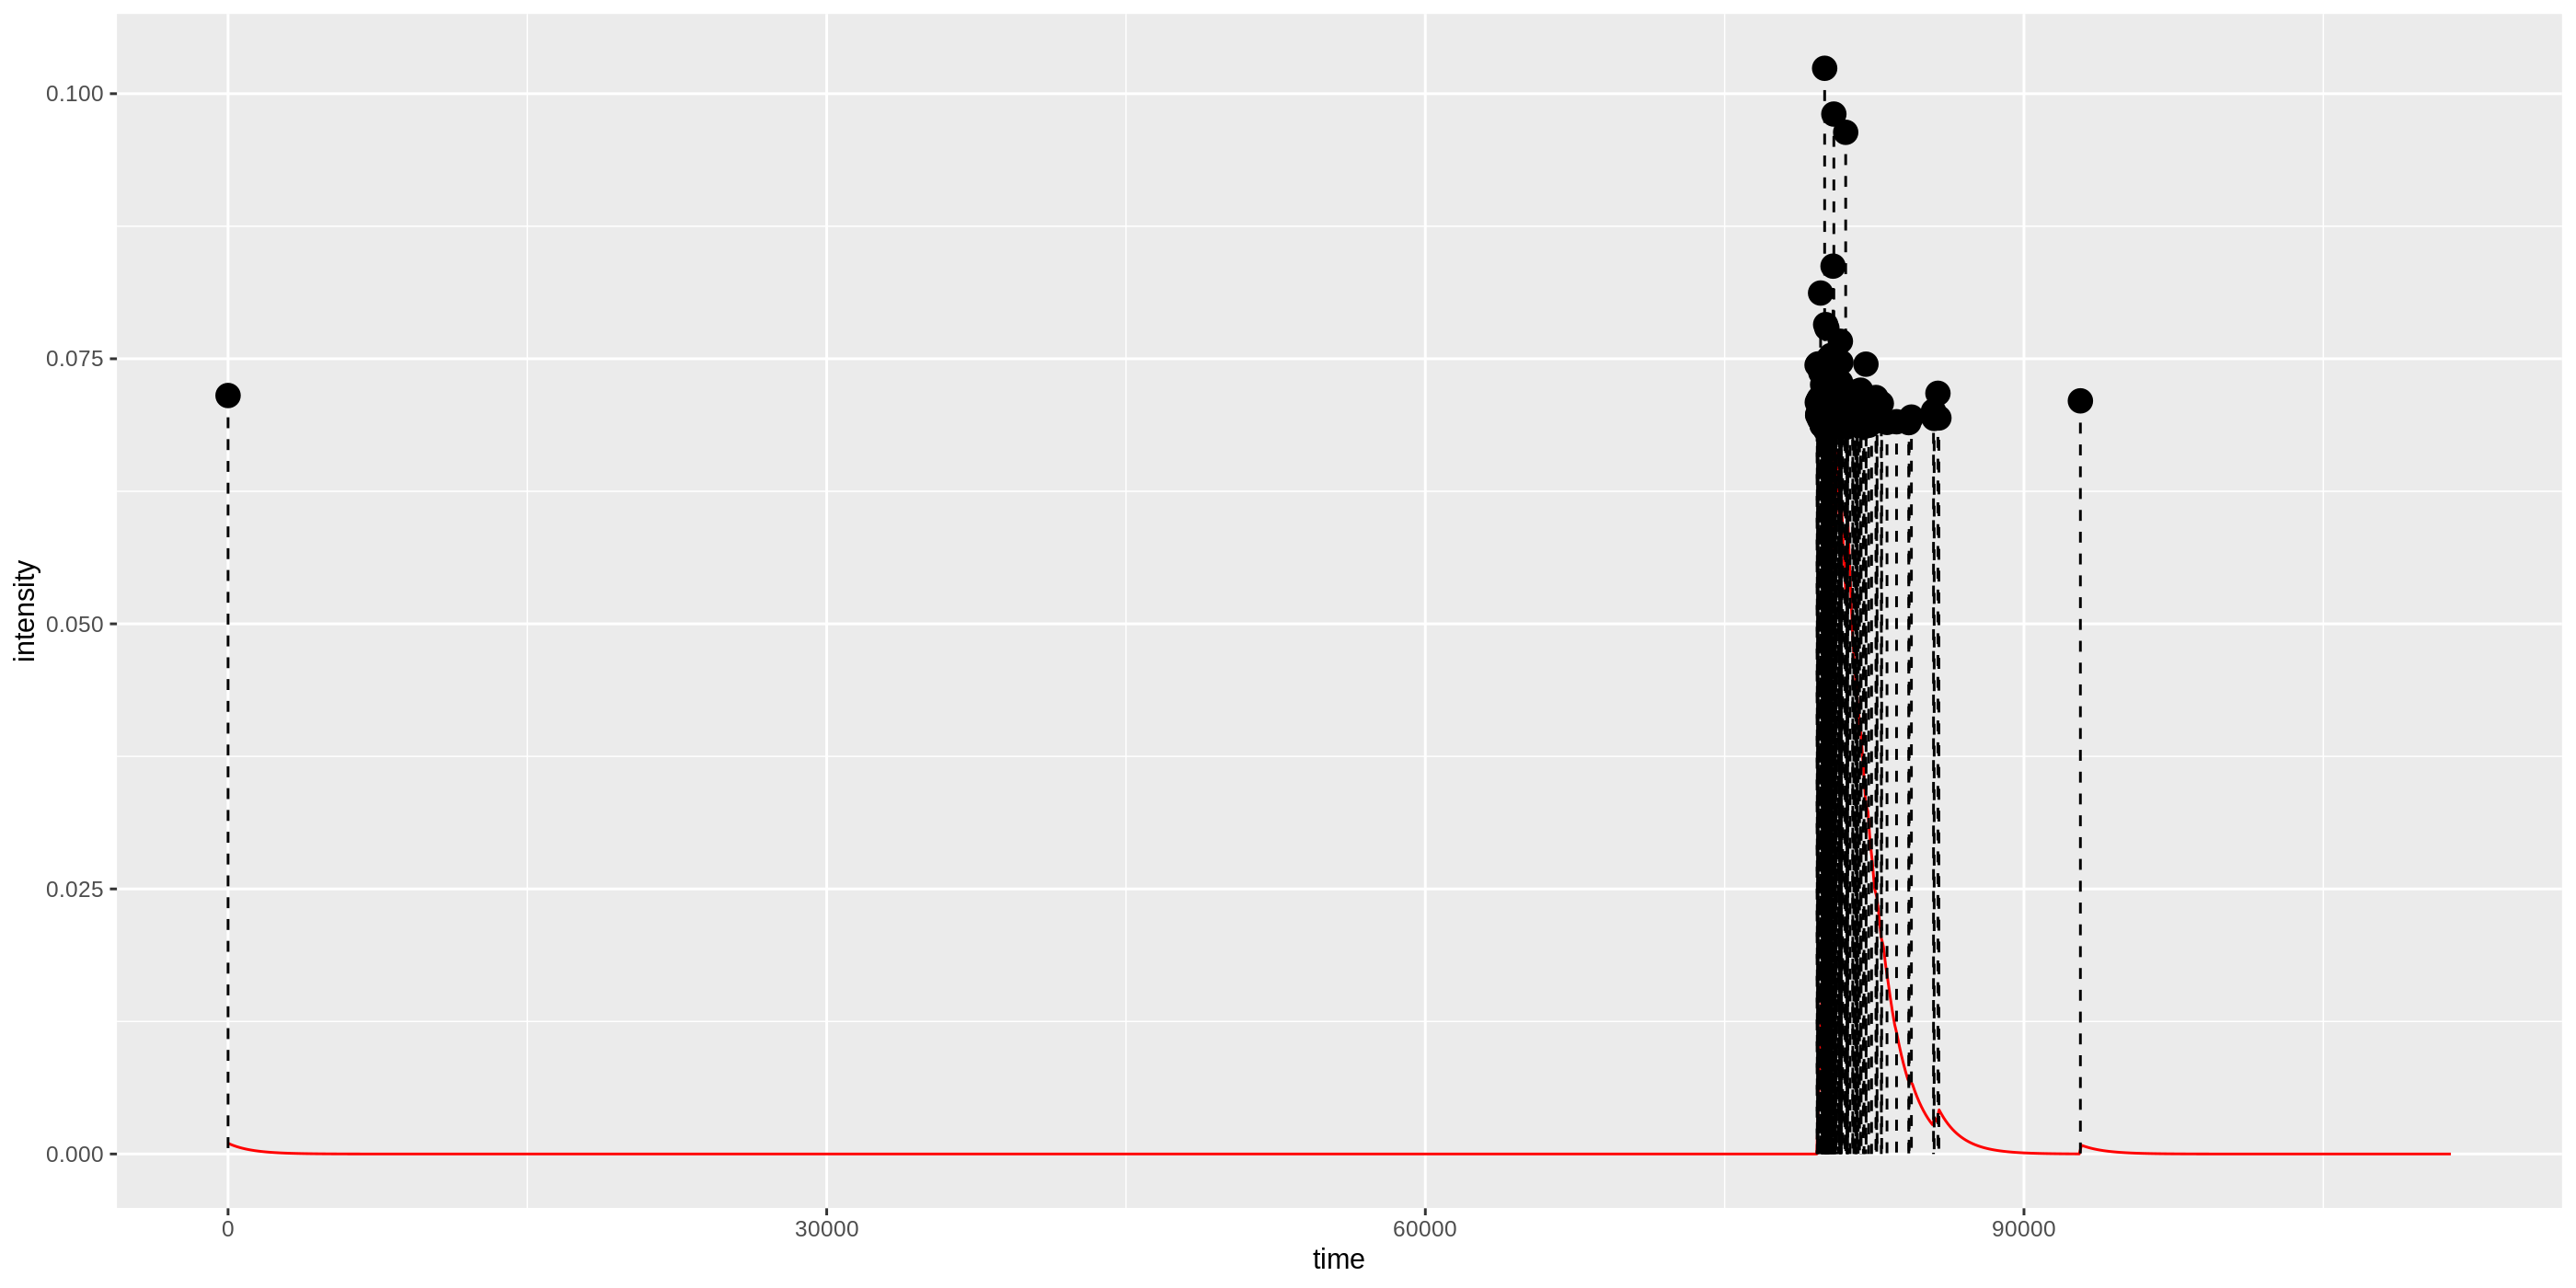

In [552]:
options(repr.plot.width=14, repr.plot.height=7, repr.plot.res = 200)
plot_event_series(fitted_model_mEXP_1)
plot_event_series(fitted_model_mEXP_2)


Testowane kaskady charakteryzują się dużą odległością kolejnych zdarzeń od pierwszego zdarzenia, przy dużym nagromadzeniu zdarzeń tuż po wystąpieniu trzeciego zdarzenia, a następnie szybkim wygaszeniem kaskady. Widoczne jest to zwłaszcza dla drugiej kaskady, gdzie następuje nagły wybuch zainteresowania, co widać w procesie Hawkesa, a następnie liczba zdarzeń szybko spada. Ze względu na dużą nieregularność w kaskadzie, będącą chwilowym gigantycznym wzrostem zainteresowania, a następnym bardzo szybkim spadkiem, wyniki działania modeli nie dziwią - były dość słabe, niemniej wynika to ze skomplikowania konstrukcji kaskad - ciężko zauważyć w nich jakiekolwiek regularne wzorce. 